In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from torchinfo import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
mps = torch.backends.mps.is_available()
cuda = torch.cuda.is_available()
device = "cpu"
if cuda:
    device = torch.device("cuda")
elif mps:
    device = torch.device("mps")

device

device(type='mps')

In [3]:
class Network(nn.Module):
    def __init__(self, dropout_ratio=0.05):
        super(Network, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 8, 3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(8, 8, 3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(8, 8, 3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.conv8 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv9 = nn.Sequential(
            nn.Conv2d(16, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.conv11 = nn.Sequential(
            nn.Conv2d(32, 10, 1),
        )
        self.gap = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool1(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.pool2(x)
        x = self.conv9(x)
        x = self.conv11(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=1)

In [4]:
model = Network(dropout_ratio=0.1).to(device)
summary(model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Network                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 8, 28, 28]            --
│    └─Conv2d: 2-1                       [1, 8, 28, 28]            80
│    └─BatchNorm2d: 2-2                  [1, 8, 28, 28]            16
│    └─ReLU: 2-3                         [1, 8, 28, 28]            --
├─Sequential: 1-2                        [1, 8, 28, 28]            --
│    └─Conv2d: 2-4                       [1, 8, 28, 28]            584
│    └─BatchNorm2d: 2-5                  [1, 8, 28, 28]            16
│    └─ReLU: 2-6                         [1, 8, 28, 28]            --
├─Sequential: 1-3                        [1, 8, 28, 28]            --
│    └─Conv2d: 2-7                       [1, 8, 28, 28]            584
│    └─BatchNorm2d: 2-8                  [1, 8, 28, 28]            16
│    └─ReLU: 2-9                         [1, 8, 28, 28]            --
├─Sequential:

In [5]:
train_transforms = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])


In [6]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

In [7]:
torch.manual_seed(1)
batch_size = 64

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 1, 'pin_memory': True} if cuda else {'batch_size': batch_size, 'shuffle': True}
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)

In [8]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {"images": [], "ground_truths": [], "predicted_vals": []}

In [9]:
def GetCorrectPredCount(pPrediction, pLabels):
    return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
    model.train()
    pbar = tqdm(train_loader)

    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Predict
        pred = model(data)

        # Calculate loss
        loss = criterion(pred, target)
        train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        correct += GetCorrectPredCount(pred, target)
        processed += len(data)

        pbar.set_description(
            desc=f"Train: Loss={loss.item()/len(train_loader):0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}"
        )

    train_acc.append(100 * correct / processed)
    train_losses.append(train_loss / len(train_loader))


def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.inference_mode():
        for _, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()

            correct += GetCorrectPredCount(output, target)

    test_loss /= len(test_loader.dataset)
    test_acc.append(100.0 * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )


def plot_images(dataloader):
    batch_data, batch_label = next(iter(dataloader))

    fig = plt.figure()

    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.tight_layout()
        plt.imshow(batch_data[i].squeeze(0), cmap="gray")
        plt.title(batch_label[i].item())
        plt.xticks([])
        plt.yticks([])


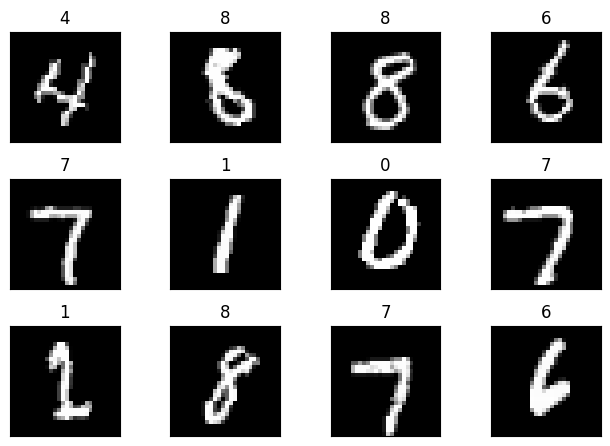

In [10]:
plot_images(train_loader)

In [11]:
model = Network(dropout_ratio=0.05).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)
# New Line
criterion = nn.CrossEntropyLoss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  optimizer.step()
  # optimizer.get_last_lr()

/Users/kaustubh/.virtualenvs/era/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1


Train: Loss=0.0001 Batch_id=937 Accuracy=93.12: 100%|██████████| 938/938 [00:17<00:00, 53.07it/s]


Test set: Average loss: 0.0011, Accuracy: 9802/10000 (98.02%)

Epoch 2


Train: Loss=0.0000 Batch_id=937 Accuracy=97.88: 100%|██████████| 938/938 [00:17<00:00, 55.03it/s]


Test set: Average loss: 0.0005, Accuracy: 9896/10000 (98.96%)

Epoch 3


Train: Loss=0.0000 Batch_id=937 Accuracy=98.41: 100%|██████████| 938/938 [00:17<00:00, 54.94it/s]


Test set: Average loss: 0.0008, Accuracy: 9833/10000 (98.33%)

Epoch 4


Train: Loss=0.0002 Batch_id=937 Accuracy=98.54: 100%|██████████| 938/938 [00:17<00:00, 54.99it/s]


Test set: Average loss: 0.0005, Accuracy: 9906/10000 (99.06%)

Epoch 5


Train: Loss=0.0000 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [00:17<00:00, 54.81it/s]


Test set: Average loss: 0.0003, Accuracy: 9930/10000 (99.30%)

Epoch 6


Train: Loss=0.0002 Batch_id=937 Accuracy=98.80: 100%|██████████| 938/938 [00:17<00:00, 55.06it/s]


Test set: Average loss: 0.0003, Accuracy: 9934/10000 (99.34%)

Epoch 7


Train: Loss=0.0000 Batch_id=937 Accuracy=98.91: 100%|██████████| 938/938 [00:17<00:00, 54.25it/s]


Test set: Average loss: 0.0003, Accuracy: 9930/10000 (99.30%)

Epoch 8


Train: Loss=0.0001 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:16<00:00, 55.39it/s]


Test set: Average loss: 0.0003, Accuracy: 9947/10000 (99.47%)

Epoch 9


Train: Loss=0.0000 Batch_id=937 Accuracy=98.93: 100%|██████████| 938/938 [00:17<00:00, 53.28it/s]


Test set: Average loss: 0.0003, Accuracy: 9944/10000 (99.44%)

Epoch 10


Train: Loss=0.0000 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:16<00:00, 55.21it/s]


Test set: Average loss: 0.0003, Accuracy: 9932/10000 (99.32%)

Epoch 11


Train: Loss=0.0000 Batch_id=937 Accuracy=99.04: 100%|██████████| 938/938 [00:16<00:00, 55.22it/s]


Test set: Average loss: 0.0002, Accuracy: 9948/10000 (99.48%)

Epoch 12


Train: Loss=0.0000 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:17<00:00, 55.06it/s]


Test set: Average loss: 0.0002, Accuracy: 9949/10000 (99.49%)

Epoch 13


Train: Loss=0.0000 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [00:17<00:00, 55.09it/s]


Test set: Average loss: 0.0002, Accuracy: 9950/10000 (99.50%)

Epoch 14


Train: Loss=0.0000 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:17<00:00, 54.21it/s]


Test set: Average loss: 0.0003, Accuracy: 9932/10000 (99.32%)

Epoch 15


Train: Loss=0.0000 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [00:17<00:00, 55.18it/s]


Test set: Average loss: 0.0002, Accuracy: 9950/10000 (99.50%)

Epoch 16


Train: Loss=0.0000 Batch_id=937 Accuracy=99.24: 100%|██████████| 938/938 [00:17<00:00, 54.73it/s]


Test set: Average loss: 0.0003, Accuracy: 9950/10000 (99.50%)

Epoch 17


Train: Loss=0.0000 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [00:17<00:00, 54.72it/s]


Test set: Average loss: 0.0003, Accuracy: 9949/10000 (99.49%)

Epoch 18


Train: Loss=0.0001 Batch_id=937 Accuracy=99.15: 100%|██████████| 938/938 [00:17<00:00, 54.73it/s]


Test set: Average loss: 0.0002, Accuracy: 9948/10000 (99.48%)

Epoch 19


Train: Loss=0.0000 Batch_id=937 Accuracy=99.24: 100%|██████████| 938/938 [00:17<00:00, 54.85it/s]


Test set: Average loss: 0.0002, Accuracy: 9950/10000 (99.50%)

Epoch 20


Train: Loss=0.0000 Batch_id=937 Accuracy=99.36: 100%|██████████| 938/938 [00:16<00:00, 55.22it/s]


Test set: Average loss: 0.0003, Accuracy: 9955/10000 (99.55%)



Text(0.5, 1.0, 'Test Accuracy')

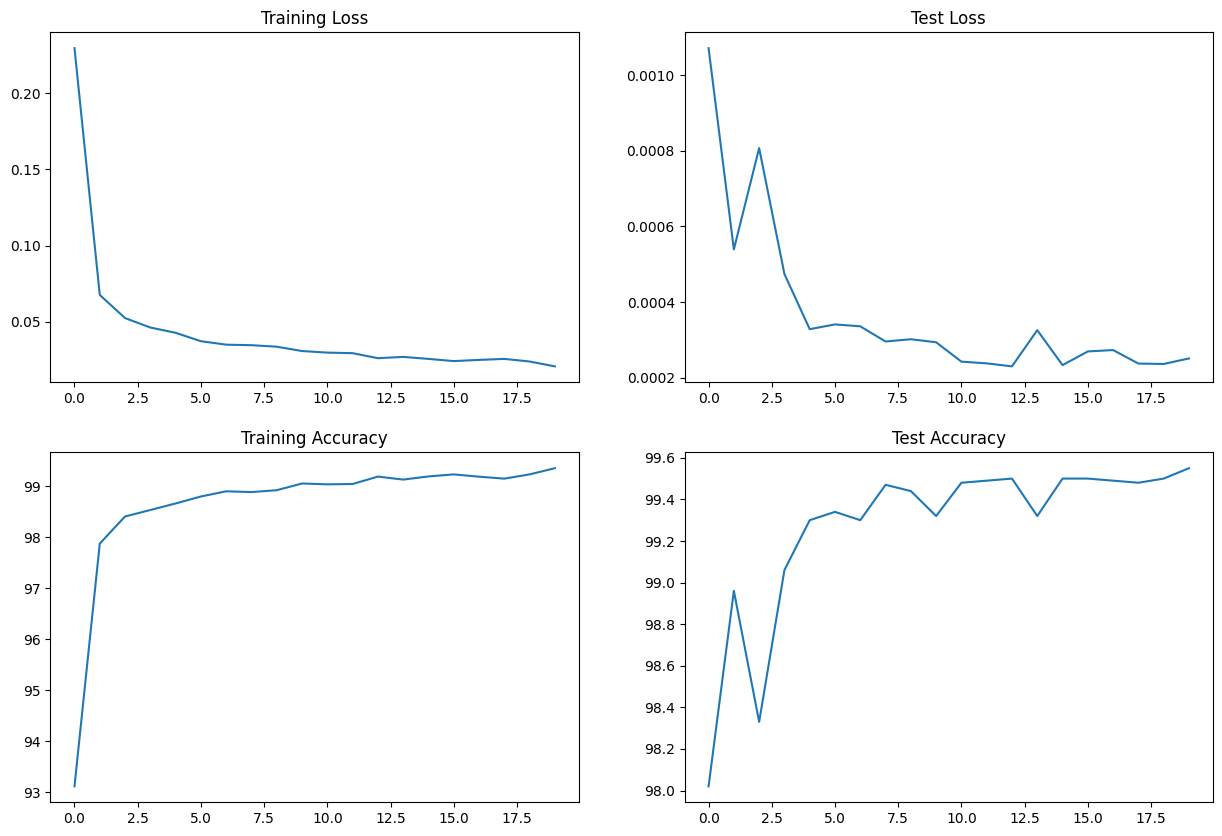

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [15]:
class Network2(nn.Module):
    def __init__(self, dropout_ratio=0.05):
        super(Network2, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 4, 3, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(4, 4, 3, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(4, 4, 3, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(4, 4, 3, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Sequential(
            nn.Conv2d(4, 8, 3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(8, 8, 3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(8, 8, 3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        self.conv8 = nn.Sequential(
            nn.Conv2d(8, 8, 3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv9 = nn.Sequential(
            nn.Conv2d(8, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.conv11 = nn.Sequential(
            nn.Conv2d(16, 10, 1),
        )
        self.gap = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool1(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.pool2(x)
        x = self.conv9(x)
        x = self.conv11(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=1)

In [16]:
model = Network2(dropout_ratio=0.1).to(device)
summary(model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Network2                                 [1, 10]                   --
├─Sequential: 1-1                        [1, 4, 28, 28]            --
│    └─Conv2d: 2-1                       [1, 4, 28, 28]            40
│    └─BatchNorm2d: 2-2                  [1, 4, 28, 28]            8
│    └─ReLU: 2-3                         [1, 4, 28, 28]            --
├─Sequential: 1-2                        [1, 4, 28, 28]            --
│    └─Conv2d: 2-4                       [1, 4, 28, 28]            148
│    └─BatchNorm2d: 2-5                  [1, 4, 28, 28]            8
│    └─ReLU: 2-6                         [1, 4, 28, 28]            --
├─Sequential: 1-3                        [1, 4, 28, 28]            --
│    └─Conv2d: 2-7                       [1, 4, 28, 28]            148
│    └─BatchNorm2d: 2-8                  [1, 4, 28, 28]            8
│    └─ReLU: 2-9                         [1, 4, 28, 28]            --
├─Sequential: 1-

In [17]:
model = Network2(dropout_ratio=0.05).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
# New Line
criterion = nn.CrossEntropyLoss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  optimizer.step()


Epoch 1


Train: Loss=0.0001 Batch_id=937 Accuracy=90.05: 100%|██████████| 938/938 [00:18<00:00, 50.81it/s]


Test set: Average loss: 0.0014, Accuracy: 9724/10000 (97.24%)

Epoch 2


Train: Loss=0.0000 Batch_id=937 Accuracy=96.94: 100%|██████████| 938/938 [00:16<00:00, 57.02it/s]


Test set: Average loss: 0.0019, Accuracy: 9617/10000 (96.17%)

Epoch 3


Train: Loss=0.0000 Batch_id=937 Accuracy=97.39: 100%|██████████| 938/938 [00:15<00:00, 59.38it/s]


Test set: Average loss: 0.0009, Accuracy: 9842/10000 (98.42%)

Epoch 4


Train: Loss=0.0001 Batch_id=937 Accuracy=97.91: 100%|██████████| 938/938 [00:15<00:00, 59.48it/s]


Test set: Average loss: 0.0007, Accuracy: 9852/10000 (98.52%)

Epoch 5


Train: Loss=0.0000 Batch_id=937 Accuracy=98.11: 100%|██████████| 938/938 [00:16<00:00, 56.79it/s]


Test set: Average loss: 0.0006, Accuracy: 9873/10000 (98.73%)

Epoch 6


Train: Loss=0.0001 Batch_id=937 Accuracy=98.17: 100%|██████████| 938/938 [00:16<00:00, 55.80it/s]


Test set: Average loss: 0.0007, Accuracy: 9854/10000 (98.54%)

Epoch 7


Train: Loss=0.0001 Batch_id=937 Accuracy=98.19: 100%|██████████| 938/938 [00:16<00:00, 55.43it/s]


Test set: Average loss: 0.0008, Accuracy: 9826/10000 (98.26%)

Epoch 8


Train: Loss=0.0000 Batch_id=937 Accuracy=98.34: 100%|██████████| 938/938 [00:17<00:00, 54.81it/s]


Test set: Average loss: 0.0007, Accuracy: 9836/10000 (98.36%)

Epoch 9


Train: Loss=0.0000 Batch_id=937 Accuracy=98.36: 100%|██████████| 938/938 [00:16<00:00, 55.33it/s]


Test set: Average loss: 0.0004, Accuracy: 9908/10000 (99.08%)

Epoch 10


Train: Loss=0.0003 Batch_id=937 Accuracy=98.49: 100%|██████████| 938/938 [00:16<00:00, 55.36it/s]


Test set: Average loss: 0.0004, Accuracy: 9905/10000 (99.05%)

Epoch 11


Train: Loss=0.0002 Batch_id=937 Accuracy=98.49: 100%|██████████| 938/938 [00:16<00:00, 55.53it/s]


Test set: Average loss: 0.0004, Accuracy: 9907/10000 (99.07%)

Epoch 12


Train: Loss=0.0004 Batch_id=937 Accuracy=98.65: 100%|██████████| 938/938 [00:17<00:00, 55.12it/s]


Test set: Average loss: 0.0004, Accuracy: 9918/10000 (99.18%)

Epoch 13


Train: Loss=0.0000 Batch_id=937 Accuracy=98.53: 100%|██████████| 938/938 [00:16<00:00, 55.51it/s]


Test set: Average loss: 0.0004, Accuracy: 9916/10000 (99.16%)

Epoch 14


Train: Loss=0.0000 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:16<00:00, 55.66it/s]


Test set: Average loss: 0.0004, Accuracy: 9915/10000 (99.15%)

Epoch 15


Train: Loss=0.0000 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [00:17<00:00, 54.94it/s]


Test set: Average loss: 0.0004, Accuracy: 9919/10000 (99.19%)

Epoch 16


Train: Loss=0.0000 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:16<00:00, 55.56it/s]


Test set: Average loss: 0.0004, Accuracy: 9924/10000 (99.24%)

Epoch 17


Train: Loss=0.0002 Batch_id=937 Accuracy=98.79: 100%|██████████| 938/938 [00:16<00:00, 55.46it/s]


Test set: Average loss: 0.0003, Accuracy: 9919/10000 (99.19%)

Epoch 18


Train: Loss=0.0000 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:16<00:00, 55.64it/s]


Test set: Average loss: 0.0003, Accuracy: 9927/10000 (99.27%)

Epoch 19


Train: Loss=0.0001 Batch_id=937 Accuracy=98.74: 100%|██████████| 938/938 [00:17<00:00, 54.83it/s]


Test set: Average loss: 0.0003, Accuracy: 9940/10000 (99.40%)

Epoch 20


Train: Loss=0.0001 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [00:17<00:00, 54.38it/s]


Test set: Average loss: 0.0005, Accuracy: 9895/10000 (98.95%)



Text(0.5, 1.0, 'Test Accuracy')

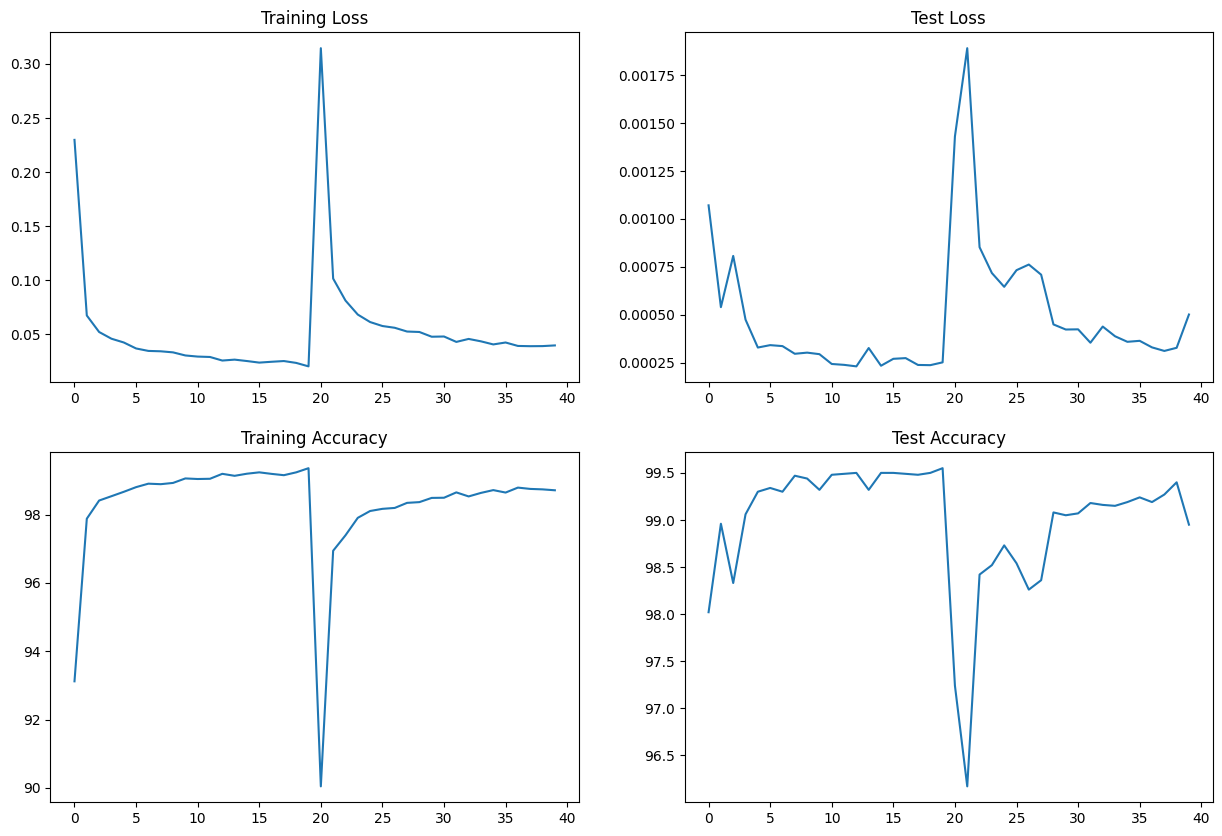

In [18]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")